
0: 960x1280 1 frame, 1 table, 1 white ball, 1 yellow ball, 38.1ms
Speed: 7.3ms preprocess, 38.1ms inference, 1.4ms postprocess per image at shape (1, 3, 960, 1280)
Table: {'cls_name': 'table', 'x1': tensor(162.6537, device='cuda:0'), 'y1': tensor(138.5501, device='cuda:0'), 'x2': tensor(639.7369, device='cuda:0'), 'y2': tensor(459.3559, device='cuda:0'), 'confidence': tensor(0.9323, device='cuda:0')}
Objects: [{'cls_name': 'white ball', 'x1': tensor(485.0375, device='cuda:0'), 'y1': tensor(201.8281, device='cuda:0'), 'x2': tensor(498.1712, device='cuda:0'), 'y2': tensor(218.2779, device='cuda:0'), 'confidence': tensor(0.8874, device='cuda:0')}, {'cls_name': 'frame', 'x1': tensor(137.7367, device='cuda:0'), 'y1': tensor(102.1826, device='cuda:0'), 'x2': tensor(666.5446, device='cuda:0'), 'y2': tensor(493.6065, device='cuda:0'), 'confidence': tensor(0.8665, device='cuda:0')}, {'cls_name': 'yellow ball', 'x1': tensor(419.7611, device='cuda:0'), 'y1': tensor(198.9554, device='cuda:0'), 'x

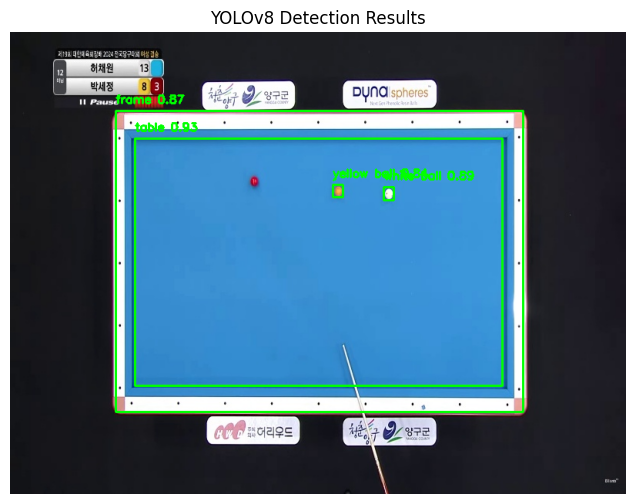

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline  

from ultralytics import YOLO
import cv2
import torch

# 1) YOLO 모델 로드
model_path = "best_jihye.pt"
model = YOLO(model_path)

# 2) 이미지 로드
image_path = "frame_9400.jpg"
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Could not load image: {image_path}")

# 3) 모델 추론
results = model.predict(source=image, conf=0.5)

# 4) 당구대, 공, 프레임 등 저장할 구조
table = None
objects = []

# 5) 바운딩 박스 표시
for result in results:
    for box in result.boxes:
        # 바운딩 박스 정보
        x1, y1, x2, y2 = box.xyxy[0]
        conf = box.conf[0]
        cls_id = int(box.cls[0])

        # 사각형 그리기 위한 int 변환
        ix1, iy1, ix2, iy2 = map(int, [x1, y1, x2, y2])

        # 클래스 ID → 이름 매핑
        class_map = {
            0: "blue ball", 
            1: "frame", 
            2: "red ball", 
            3: "table",
            4: "white ball", 
            5: "yellow ball"
        }
        cls_name = class_map.get(cls_id, f"Unknown({cls_id})")

        # OpenCV로 바운딩 박스 그리기
        cv2.rectangle(image, (ix1, iy1), (ix2, iy2), (0, 255, 0), 2)

        # 라벨(클래스명 + 신뢰도) 표시
        label = f"{cls_name} {conf:.2f}"
        cv2.putText(
            image, label, (ix1, max(iy1 - 10, 0)),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2
        )

        # 아래는 원하는 로직에 따라 table/objects 분류
        if cls_id == 3:  # table
            table = {
                "cls_name": "table",
                "x1": x1, "y1": y1, "x2": x2, "y2": y2,
                "confidence": conf
            }
        else:
            objects.append({
                "cls_name": cls_name,
                "x1": x1, "y1": y1, "x2": x2, "y2": y2,
                "confidence": conf
            })

# 테이블 없으면 기본값
if table is None:
    table = {
        "cls_name": "table(default)",
        "x1": 0, "y1": 0, "x2": 1280, "y2": 720,
        "confidence": 1.0
    }

print("Table:", table)
print("Objects:", objects)

# 시각화(디버깅용)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 6))
plt.imshow(image_rgb)
plt.axis("off")
plt.title("YOLOv8 Detection Results")
plt.show()


[충돌] type1 <-> type3, velA=Vec2d(-0.05805591369382574, 0.011560450050783466), velB=Vec2d(-0.5530589672937961, 0.11012849785229038)
[최종 위치] 흰공: (249.41, 390.31)
[최종 위치] 빨강공: (326.20, 360.47)
[최종 위치] 노랑공: (329.46, 263.42)


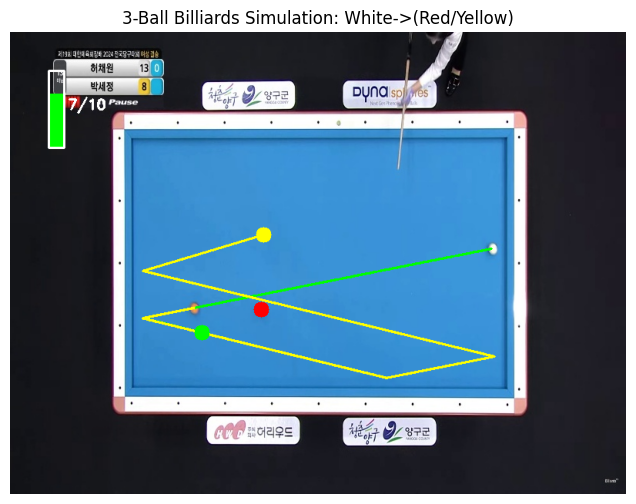

In [26]:
import pymunk
from pymunk import Vec2d
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt

##############################################################################
# 0) 헬퍼 함수: GPU 텐서 -> CPU float 변환
##############################################################################
def to_cpu_float(value):
    if isinstance(value, torch.Tensor):
        return float(value.detach().cpu().item())
    return float(value)

##############################################################################
# 1) 공, 테이블 좌표 추출
#    - objects 내에 white ball, red ball, yellow ball이 모두 있다고 가정
##############################################################################
white_ball = next(obj for obj in objects if obj["cls_name"] == "white ball")
red_ball   = next(obj for obj in objects if obj["cls_name"] == "red ball")
yellow_ball= next(obj for obj in objects if obj["cls_name"] == "yellow ball")

# x1, y1, x2, y2 좌표 추출 + float 변환
wx1, wy1 = to_cpu_float(white_ball["x1"]), to_cpu_float(white_ball["y1"])
wx2, wy2 = to_cpu_float(white_ball["x2"]), to_cpu_float(white_ball["y2"])

rx1, ry1 = to_cpu_float(red_ball["x1"]), to_cpu_float(red_ball["y1"])
rx2, ry2 = to_cpu_float(red_ball["x2"]), to_cpu_float(red_ball["y2"])

yx1, yy1 = to_cpu_float(yellow_ball["x1"]), to_cpu_float(yellow_ball["y1"])
yx2, yy2 = to_cpu_float(yellow_ball["x2"]), to_cpu_float(yellow_ball["y2"])

# 중심점(픽셀)
white_pos_px  = np.array([(wx1 + wx2) / 2.0, (wy1 + wy2) / 2.0])
red_pos_px    = np.array([(rx1 + rx2) / 2.0, (ry1 + ry2) / 2.0])
yellow_pos_px = np.array([(yx1 + yx2) / 2.0, (yy1 + yy2) / 2.0])

# 테이블 정보
# 예: table["x1"], table["y1"], table["x2"], table["y2"]
table_min_x = to_cpu_float(table["x1"])
table_min_y = to_cpu_float(table["y1"])
table_max_x = to_cpu_float(table["x2"])
table_max_y = to_cpu_float(table["y2"])

# 픽셀 → 월드 좌표 변환
PIXELS_TO_METERS = 100.0
white_pos_world  = (white_pos_px  / PIXELS_TO_METERS).tolist()
red_pos_world    = (red_pos_px    / PIXELS_TO_METERS).tolist()
yellow_pos_world = (yellow_pos_px / PIXELS_TO_METERS).tolist()

table_min_x_world = table_min_x / PIXELS_TO_METERS
table_min_y_world = table_min_y / PIXELS_TO_METERS
table_max_x_world = table_max_x / PIXELS_TO_METERS
table_max_y_world = table_max_y / PIXELS_TO_METERS

##############################################################################
# 2) Pymunk 초기화 + 테이블 경계
##############################################################################
space = pymunk.Space()
space.gravity = (0, 0)

# 공이 테이블 밖으로 못 나가도록,
# '공 반지름'만큼 안쪽에 쿠션(4개 세그먼트) 생성
mass = 1.0
radius = 0.05  # 5cm
moment = pymunk.moment_for_circle(mass, 0, radius)

left   = table_min_x_world + radius
right  = table_max_x_world - radius
bottom = table_min_y_world + radius
top    = table_max_y_world - radius

cushion_thickness = 0.01
cushions = [
    pymunk.Segment(space.static_body, (left, bottom), (right, bottom), cushion_thickness),
    pymunk.Segment(space.static_body, (left, top),    (right, top),    cushion_thickness),
    pymunk.Segment(space.static_body, (left, bottom), (left, top),     cushion_thickness),
    pymunk.Segment(space.static_body, (right, bottom),(right, top),    cushion_thickness),
]
for c in cushions:
    c.elasticity = 0.9
    c.friction = 0.01
    space.add(c)

##############################################################################
# 3) 공 3개 생성 (흰=1, 빨강=2, 노랑=3)
##############################################################################
# -- 흰 공
white_body = pymunk.Body(mass, moment)
white_body.position = white_pos_world
white_shape = pymunk.Circle(white_body, radius)
white_shape.elasticity = 0.9
white_shape.friction = 0.05
white_shape.collision_type = 1
space.add(white_body, white_shape)

# -- 빨간 공
red_body = pymunk.Body(mass, moment)
red_body.position = red_pos_world
red_shape = pymunk.Circle(red_body, radius)
red_shape.elasticity = 0.9
red_shape.friction = 0.05
red_shape.collision_type = 2
space.add(red_body, red_shape)

# -- 노란 공
yellow_body = pymunk.Body(mass, moment)
yellow_body.position = yellow_pos_world
yellow_shape = pymunk.Circle(yellow_body, radius)
yellow_shape.elasticity = 0.9
yellow_shape.friction = 0.05
yellow_shape.collision_type = 3
space.add(yellow_body, yellow_shape)

##############################################################################
# 4) 충돌 핸들러 등록
#    (1,2) 흰-빨강, (1,3) 흰-노랑, (2,3) 빨강-노랑
##############################################################################
def collision_post_solve(arbiter, space, data):
    """
    Pymunk 기본 탄성 충돌로 속도를 자동 계산.
    여기서는 별도 조정 없이 '로그'만 출력.
    """
    sA, sB = arbiter.shapes
    print(f"[충돌] type{ sA.collision_type } <-> type{ sB.collision_type },"
          f" velA={sA.body.velocity}, velB={sB.body.velocity}")
    return True

for ctypeA, ctypeB in [(1,2), (1,3), (2,3)]:
    handler = space.add_collision_handler(ctypeA, ctypeB)
    handler.post_solve = collision_post_solve

##############################################################################
# 5) 흰 공 초기 속도 부여 (노란 공 방향)
##############################################################################
strength_gauge = 7  # 1~10
max_speed = 1.0      # 게이지 10이면 5 m/s
initial_speed = (strength_gauge / 10.0) * max_speed

direction_vec = (yellow_body.position - white_body.position)
distance = direction_vec.length
direction_unit = direction_vec.normalized() if distance > 0 else Vec2d(1, 0)

white_body.velocity = direction_unit * initial_speed

##############################################################################
# 6) 시뮬레이션 수행
##############################################################################
dt = 1/60.0
max_steps = 3000
stop_threshold = 0.02

# 궤적 저장
positions_white  = []
positions_red    = []
positions_yellow = []

global_friction_coef = 0.02

for step in range(max_steps):
    space.step(dt)

    # 추가 마찰(테이블 표면)
    white_body.velocity  *= (1 - global_friction_coef * dt)
    red_body.velocity    *= (1 - global_friction_coef * dt)
    yellow_body.velocity *= (1 - global_friction_coef * dt)

    # 느리면 정지 처리
    if white_body.velocity.length < stop_threshold:
        white_body.velocity = Vec2d(0, 0)
    if red_body.velocity.length < stop_threshold:
        red_body.velocity = Vec2d(0, 0)
    if yellow_body.velocity.length < stop_threshold:
        yellow_body.velocity = Vec2d(0, 0)

    positions_white.append( (white_body.position.x,  white_body.position.y) )
    positions_red.append(   (red_body.position.x,    red_body.position.y) )
    positions_yellow.append((yellow_body.position.x, yellow_body.position.y) )

    # 세 공 모두 멈추면 종료
    if (white_body.velocity.length == 0 and
        red_body.velocity.length == 0 and
        yellow_body.velocity.length == 0):
        print(f"[시뮬레이션 종료] Step {step}")
        break

##############################################################################
# 7) 최종 결과 출력
##############################################################################
final_wpos = white_body.position * PIXELS_TO_METERS
final_rpos = red_body.position   * PIXELS_TO_METERS
final_ypos = yellow_body.position* PIXELS_TO_METERS

print(f"[최종 위치] 흰공: ({final_wpos.x:.2f}, {final_wpos.y:.2f})")
print(f"[최종 위치] 빨강공: ({final_rpos.x:.2f}, {final_rpos.y:.2f})")
print(f"[최종 위치] 노랑공: ({final_ypos.x:.2f}, {final_ypos.y:.2f})")

##############################################################################
# 8) 궤적 시각화 (OpenCV)
##############################################################################
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Could not load image: {image_path}")

# (white=녹색, red=빨강, yellow=노랑)으로 라인 그리기
def draw_trajectory(img, positions, color_bgr, px_to_m=PIXELS_TO_METERS):
    for i in range(len(positions)-1):
        x1, y1 = positions[i]
        x2, y2 = positions[i+1]
        cv2.line(img,
                 (int(x1*px_to_m), int(y1*px_to_m)),
                 (int(x2*px_to_m), int(y2*px_to_m)),
                 color_bgr, 2)

# 궤적 그리기
draw_trajectory(image, positions_white,  (0, 255, 0))     # 흰 공: 녹색
draw_trajectory(image, positions_red,    (0, 0, 255))     # 빨간 공: 빨강(BGR이므로)
draw_trajectory(image, positions_yellow, (0, 255, 255))   # 노란 공: 노랑

# 최종 위치 점 찍기
cv2.circle(image, (int(final_wpos.x), int(final_wpos.y)), 10, (0, 255, 0), -1)
cv2.circle(image, (int(final_rpos.x), int(final_rpos.y)), 10, (0, 0, 255), -1)
cv2.circle(image, (int(final_ypos.x), int(final_ypos.y)), 10, (0, 255, 255), -1)

##############################################################################
# 9) 강도 게이지 표시 (좌측 상단)
##############################################################################
gauge_max_height = 100
gauge_height = int((strength_gauge / 10) * gauge_max_height)
gauge_x, gauge_y = 50, 50
gauge_width = 20

cv2.rectangle(
    image,
    (gauge_x, gauge_y + gauge_max_height - gauge_height),
    (gauge_x + gauge_width, gauge_y + gauge_max_height),
    (0, 255, 0),
    -1
)
cv2.rectangle(
    image,
    (gauge_x, gauge_y),
    (gauge_x + gauge_width, gauge_y + gauge_max_height),
    (255, 255, 255),
    2
)
cv2.putText(
    image,
    f"{strength_gauge}/10",
    (gauge_x + gauge_width + 5, gauge_y + gauge_max_height // 2),
    cv2.FONT_HERSHEY_SIMPLEX,
    0.6,
    (255, 255, 255),
    2
)

# matplotlib 시각화
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8, 6))
plt.imshow(image_rgb)
plt.axis("off")
plt.title("3-Ball Billiards Simulation: White->(Red/Yellow)")
plt.show()


[충돌] type1 <-> type3, velA=Vec2d(0.07429642947138415, 0.0), velB=Vec2d(0.7077712491747651, 0.0)
[충돌] type2 <-> type3, velA=Vec2d(0.6240910539543538, 0.0), velB=Vec2d(0.06551232058084366, 0.0)
[충돌] type2 <-> type3, velA=Vec2d(0.009911199151848238, 0.0), velB=Vec2d(-0.39703968624796726, 0.0)
[충돌] type2 <-> type3, velA=Vec2d(0.0, 0.0), velB=Vec2d(-0.39690733968588454, 0.0)
[충돌] type1 <-> type3, velA=Vec2d(-0.3415729350512274, 0.0), velB=Vec2d(0.01926161094272738, 0.0)
[충돌] type1 <-> type3, velA=Vec2d(0.017895770625212998, 0.0), velB=Vec2d(0.17048076227176606, 0.0)
[충돌] type1 <-> type3, velA=Vec2d(0.0, 0.0), velB=Vec2d(0.1704239353510088, 0.0)
[충돌] type2 <-> type3, velA=Vec2d(0.1425161840200258, 0.0), velB=Vec2d(0.014960262410941921, 0.0)
[최종 위치] 흰공:   (254.73, 150.00)
[최종 위치] 노랑공: (329.45, 150.00)
[최종 위치] 빨강공: (450.08, 150.00)


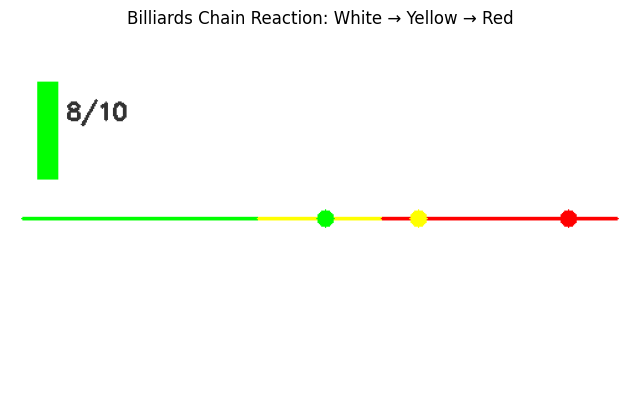

[충돌] type1 <-> type3, velA=(-0.07,0.01), velB=(-0.64,0.13)
[최종 위치] 흰공:   (273.30, 396.16)
[최종 위치] 빨강공: (326.20, 360.47)
[최종 위치] 노랑공: (478.81, 218.88)


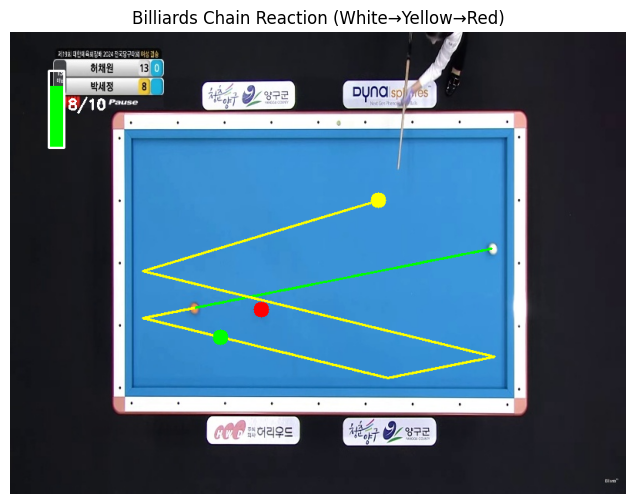

In [17]:
import pymunk
from pymunk import Vec2d
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt

##############################################################################
# 0) 헬퍼 함수: GPU 텐서 -> CPU float 변환
##############################################################################
def to_cpu_float(value):
    """
    만약 'value'가 GPU 상의 torch.Tensor라면, CPU로 이동한 뒤 float으로 변환.
    일반 float/int라면 그냥 float(value).
    """
    if isinstance(value, torch.Tensor):
        return float(value.detach().cpu().item())
    return float(value)

##############################################################################
# 1) 공, 테이블 좌표 추출
#    - objects 내에 white ball, red ball, yellow ball이 있다고 가정
#    - table에도 (x1,y1,x2,y2) 좌표가 있다고 가정
#    - 픽셀 단위 좌표 → PyMunk용 월드 좌표(미터) 변환 준비
##############################################################################
# 'objects'와 'table'은 이미 YOLO에서 가져온 전역 변수라고 가정
white_ball = next(obj for obj in objects if obj["cls_name"] == "white ball")
red_ball   = next(obj for obj in objects if obj["cls_name"] == "red ball")
yellow_ball= next(obj for obj in objects if obj["cls_name"] == "yellow ball")

# 공들의 bounding box 좌표(픽셀)
wx1, wy1 = to_cpu_float(white_ball["x1"]), to_cpu_float(white_ball["y1"])
wx2, wy2 = to_cpu_float(white_ball["x2"]), to_cpu_float(white_ball["y2"])

rx1, ry1 = to_cpu_float(red_ball["x1"]), to_cpu_float(red_ball["y1"])
rx2, ry2 = to_cpu_float(red_ball["x2"]), to_cpu_float(red_ball["y2"])

yx1, yy1 = to_cpu_float(yellow_ball["x1"]), to_cpu_float(yellow_ball["y1"])
yx2, yy2 = to_cpu_float(yellow_ball["x2"]), to_cpu_float(yellow_ball["y2"])

# 각 공의 중심점(픽셀)
white_pos_px  = np.array([ (wx1+wx2)/2.0, (wy1+wy2)/2.0 ])
red_pos_px    = np.array([ (rx1+rx2)/2.0, (ry1+ry2)/2.0 ])
yellow_pos_px = np.array([ (yx1+yx2)/2.0, (yy1+yy2)/2.0 ])

# 테이블 정보 (픽셀)
table_min_x = to_cpu_float(table["x1"])
table_min_y = to_cpu_float(table["y1"])
table_max_x = to_cpu_float(table["x2"])
table_max_y = to_cpu_float(table["y2"])

##############################################################################
# 2) 픽셀 → 월드 좌표 변환
#    - 예시: 1m = 100px 라고 가정
##############################################################################
PIXELS_TO_METERS = 100.0

white_pos_world  = (white_pos_px  / PIXELS_TO_METERS).tolist()  # ex) [x(m), y(m)]
red_pos_world    = (red_pos_px    / PIXELS_TO_METERS).tolist()
yellow_pos_world = (yellow_pos_px / PIXELS_TO_METERS).tolist()

table_min_x_world = table_min_x / PIXELS_TO_METERS
table_min_y_world = table_min_y / PIXELS_TO_METERS
table_max_x_world = table_max_x / PIXELS_TO_METERS
table_max_y_world = table_max_y / PIXELS_TO_METERS

##############################################################################
# 3) Pymunk 초기화 + 테이블 경계(쿠션) 생성
##############################################################################
space = pymunk.Space()
space.gravity = (0, 0)  # 수평면 상에서 공이 굴러가는 것이므로 중력=0

# 공 물리값
mass   = 1.0
radius = 0.05  # 5cm
moment = pymunk.moment_for_circle(mass, 0, radius)

# 테이블 가장자리 쿠션(4개 세그먼트)
left   = table_min_x_world + radius
right  = table_max_x_world - radius
bottom = table_min_y_world + radius
top    = table_max_y_world - radius

cushion_thickness = 0.01
cushions = [
    pymunk.Segment(space.static_body, (left, bottom), (right, bottom), cushion_thickness),
    pymunk.Segment(space.static_body, (left, top),    (right, top),    cushion_thickness),
    pymunk.Segment(space.static_body, (left, bottom), (left, top),     cushion_thickness),
    pymunk.Segment(space.static_body, (right, bottom),(right, top),    cushion_thickness),
]
# 쿠션에 탄성과 마찰을 부여
for c in cushions:
    c.elasticity = 0.9
    c.friction   = 0.01
    space.add(c)

##############################################################################
# 4) 공 3개 생성 (흰=1, 빨강=2, 노랑=3)
##############################################################################
# -- 흰 공
white_body = pymunk.Body(mass, moment)
white_body.position = white_pos_world
white_shape = pymunk.Circle(white_body, radius)
white_shape.elasticity = 0.9
white_shape.friction   = 0.05
white_shape.collision_type = 1
space.add(white_body, white_shape)

# -- 빨간 공
red_body = pymunk.Body(mass, moment)
red_body.position = red_pos_world
red_shape = pymunk.Circle(red_body, radius)
red_shape.elasticity = 0.9
red_shape.friction   = 0.05
red_shape.collision_type = 2
space.add(red_body, red_shape)

# -- 노란 공
yellow_body = pymunk.Body(mass, moment)
yellow_body.position = yellow_pos_world
yellow_shape = pymunk.Circle(yellow_body, radius)
yellow_shape.elasticity = 0.9
yellow_shape.friction   = 0.05
yellow_shape.collision_type = 3
space.add(yellow_body, yellow_shape)

##############################################################################
# 5) 충돌 핸들러 등록
#    - (1,2)=흰-빨강, (1,3)=흰-노랑, (2,3)=빨강-노랑
##############################################################################
def collision_post_solve(arbiter, space, data):
    """
    공끼리 충돌한 직후(Pymunk 계산 후) 속도를 로그로 출력
    """
    sA, sB = arbiter.shapes
    print(f"[충돌] type{sA.collision_type} <-> type{sB.collision_type}, "
          f"velA=({sA.body.velocity.x:.2f},{sA.body.velocity.y:.2f}), "
          f"velB=({sB.body.velocity.x:.2f},{sB.body.velocity.y:.2f})")
    return True

for ctypeA, ctypeB in [(1,2), (1,3), (2,3)]:
    handler = space.add_collision_handler(ctypeA, ctypeB)
    handler.post_solve = collision_post_solve

##############################################################################
# 6) 흰 공 초기 속도 부여 (노란 공 방향)
#    - 흰 공 → 노란 공 → 빨간 공 순서의 연쇄 충돌을 기대.
#    - 실제 좌표가 그러한 순서를 허용해야 함.
##############################################################################
strength_gauge = 8  # 1~10 사이. 높을수록 더 빠르게 출발.
max_speed = 1.0      # 게이지=10이면 1.0 m/s로 가정
initial_speed = (strength_gauge / 10) * max_speed

direction_vec = (yellow_body.position - white_body.position)
if direction_vec.length > 0:
    direction_unit = direction_vec.normalized()
else:
    # 혹시 흰 공과 노란 공이 같은 위치라면 임의방향
    direction_unit = Vec2d(1, 0)

white_body.velocity = direction_unit * initial_speed

##############################################################################
# 7) 시뮬레이션 수행
##############################################################################
dt = 1/60.0
max_steps = 3000
stop_threshold = 0.02  # 충분히 느려지면 정지 처리

positions_white  = []
positions_red    = []
positions_yellow = []

# 테이블 표면 마찰(전역)
global_friction_coef = 0.02

for step in range(max_steps):
    # Pymunk 물리 한 스텝
    space.step(dt)

    # 추가 마찰
    white_body.velocity  *= (1 - global_friction_coef * dt)
    red_body.velocity    *= (1 - global_friction_coef * dt)
    yellow_body.velocity *= (1 - global_friction_coef * dt)

    # 속도 작으면 0으로
    if white_body.velocity.length < stop_threshold:
        white_body.velocity = Vec2d(0, 0)
    if red_body.velocity.length < stop_threshold:
        red_body.velocity = Vec2d(0, 0)
    if yellow_body.velocity.length < stop_threshold:
        yellow_body.velocity = Vec2d(0, 0)

    positions_white.append(  (white_body.position.x,   white_body.position.y) )
    positions_red.append(    (red_body.position.x,     red_body.position.y)   )
    positions_yellow.append( (yellow_body.position.x,  yellow_body.position.y))

    # 3개 공 모두 정지 → 종료
    if (white_body.velocity.length == 0 and
        red_body.velocity.length == 0 and
        yellow_body.velocity.length == 0):
        print(f"[시뮬레이션 종료] step={step}")
        break

##############################################################################
# 8) 최종 위치 출력
##############################################################################
final_wpos = white_body.position * PIXELS_TO_METERS
final_rpos = red_body.position    * PIXELS_TO_METERS
final_ypos = yellow_body.position * PIXELS_TO_METERS

print(f"[최종 위치] 흰공:   ({final_wpos.x:.2f}, {final_wpos.y:.2f})")
print(f"[최종 위치] 빨강공: ({final_rpos.x:.2f}, {final_rpos.y:.2f})")
print(f"[최종 위치] 노랑공: ({final_ypos.x:.2f}, {final_ypos.y:.2f})")

##############################################################################
# 9) OpenCV로 궤적 시각화
#    - 실제 테이블 이미지를 불러서 그대로 그려도 되고, 여기선 그냥
#      user가 쓴 'image_path'로 로딩한다고 가정
##############################################################################
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Could not load image: {image_path}")

def draw_trajectory(img, positions, color_bgr, px_to_m=PIXELS_TO_METERS):
    """
    시뮬레이션에서 매 step 기록한 (x,y) [단위=미터]를
    line으로 이어서 궤적을 표시.
    """
    for i in range(len(positions)-1):
        x1, y1 = positions[i]
        x2, y2 = positions[i+1]
        p1 = (int(x1*px_to_m), int(y1*px_to_m))
        p2 = (int(x2*px_to_m), int(y2*px_to_m))
        cv2.line(img, p1, p2, color_bgr, 2)

# (white=녹색, red=빨강, yellow=노랑) 궤적
draw_trajectory(image, positions_white,  (0, 255, 0))
draw_trajectory(image, positions_red,    (0, 0, 255))
draw_trajectory(image, positions_yellow, (0, 255, 255))

# 최종 위치 점 찍기
cv2.circle(image, (int(final_wpos.x), int(final_wpos.y)), 10, (0, 255, 0),   -1)
cv2.circle(image, (int(final_rpos.x), int(final_rpos.y)), 10, (0, 0, 255),   -1)
cv2.circle(image, (int(final_ypos.x), int(final_ypos.y)), 10, (0, 255, 255), -1)

##############################################################################
# 10) 강도 게이지 표시 (좌측 상단)
##############################################################################
gauge_max_height = 100
gauge_height = int((strength_gauge / 10) * gauge_max_height)
gauge_x, gauge_y = 50, 50
gauge_width = 20

cv2.rectangle(
    image,
    (gauge_x, gauge_y + gauge_max_height - gauge_height),
    (gauge_x + gauge_width, gauge_y + gauge_max_height),
    (0, 255, 0),
    -1
)
cv2.rectangle(
    image,
    (gauge_x, gauge_y),
    (gauge_x + gauge_width, gauge_y + gauge_max_height),
    (255, 255, 255),
    2
)
cv2.putText(
    image,
    f"{strength_gauge}/10",
    (gauge_x + gauge_width + 5, gauge_y + gauge_max_height // 2),
    cv2.FONT_HERSHEY_SIMPLEX,
    0.6,
    (255, 255, 255),
    2
)

##############################################################################
# 11) matplotlib 시각화
##############################################################################
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 6))
plt.imshow(image_rgb)
plt.axis("off")
plt.title("Billiards Chain Reaction (White→Yellow→Red)")
plt.show()


[충돌] type1 <-> type3, velA=(-0.07,0.01), velB=(-0.64,0.13)
[최종 위치] 흰공:   (273.30, 396.16)
[최종 위치] 노랑공: (478.81, 218.88)
[최종 위치] 빨강공: (326.20, 360.47)


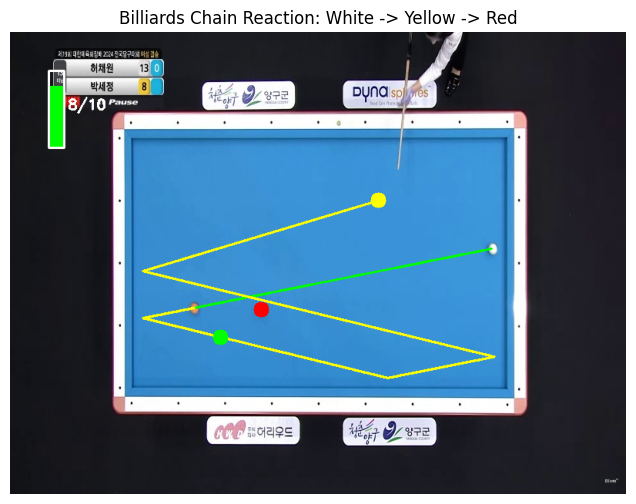

In [19]:
import pymunk
from pymunk import Vec2d
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt

##############################################################################
# 0) 헬퍼 함수: GPU 텐서 -> CPU float 변환
##############################################################################
def to_cpu_float(value):
    """
    만약 'value'가 GPU 상의 torch.Tensor라면, CPU로 이동 후 float 변환.
    일반 float/int라면 그냥 float(value).
    """
    if isinstance(value, torch.Tensor):
        return float(value.detach().cpu().item())
    return float(value)

##############################################################################
# 1) YOLO로 검출된 objects, table에서 좌표 추출
#    - objects 안에 white ball, yellow ball, red ball이 각각 존재한다고 가정
##############################################################################
# 사용 예:
# objects = [
#   {"cls_name":"white ball","x1":..., "y1":..., "x2":..., "y2":..., "confidence":...},
#   {"cls_name":"yellow ball","x1":..., "y1":..., "x2":..., "y2":..., "confidence":...},
#   {"cls_name":"red ball","x1":..., "y1":..., "x2":..., "y2":..., "confidence":...},
#   {"cls_name":"frame",...}, ...
# ]
#
# table = {
#   "cls_name":"table","x1":..., "y1":..., "x2":..., "y2":..., "confidence":...
# }
#
# 위와 같이 YOLO 추론을 통해 얻은 값이 전역변수로 있다고 가정하고,
# 여기서는 변수만 직접 참조하여 사용.
##############################################################################

white_ball  = next(obj for obj in objects if obj["cls_name"] == "white ball")
yellow_ball = next(obj for obj in objects if obj["cls_name"] == "yellow ball")
red_ball    = next(obj for obj in objects if obj["cls_name"] == "red ball")

wx1, wy1 = to_cpu_float(white_ball["x1"]), to_cpu_float(white_ball["y1"])
wx2, wy2 = to_cpu_float(white_ball["x2"]), to_cpu_float(white_ball["y2"])

yx1, yy1 = to_cpu_float(yellow_ball["x1"]), to_cpu_float(yellow_ball["y1"])
yx2, yy2 = to_cpu_float(yellow_ball["x2"]), to_cpu_float(yellow_ball["y2"])

rx1, ry1 = to_cpu_float(red_ball["x1"]), to_cpu_float(red_ball["y1"])
rx2, ry2 = to_cpu_float(red_ball["x2"]), to_cpu_float(red_ball["y2"])

# 공의 중심점(픽셀)
white_center_px  = np.array([ (wx1 + wx2)/2.0, (wy1 + wy2)/2.0 ])
yellow_center_px = np.array([ (yx1 + yx2)/2.0, (yy1 + yy2)/2.0 ])
red_center_px    = np.array([ (rx1 + rx2)/2.0, (ry1 + ry2)/2.0 ])

# 테이블
table_min_x = to_cpu_float(table["x1"])
table_min_y = to_cpu_float(table["y1"])
table_max_x = to_cpu_float(table["x2"])
table_max_y = to_cpu_float(table["y2"])

##############################################################################
# 2) 픽셀→월드 좌표 변환
#    - 예: 1m = 100px 가정
##############################################################################
PIXELS_TO_METERS = 100.0

white_pos_world  = (white_center_px  / PIXELS_TO_METERS).tolist()
yellow_pos_world = (yellow_center_px / PIXELS_TO_METERS).tolist()
red_pos_world    = (red_center_px    / PIXELS_TO_METERS).tolist()

table_min_x_world = table_min_x / PIXELS_TO_METERS
table_min_y_world = table_min_y / PIXELS_TO_METERS
table_max_x_world = table_max_x / PIXELS_TO_METERS
table_max_y_world = table_max_y / PIXELS_TO_METERS

##############################################################################
# 3) Pymunk 공간 초기화 + 테이블 쿠션 생성
##############################################################################
space = pymunk.Space()
space.gravity = (0, 0)  # 중력=0, 수평면 상에서 굴러가는 상황

mass   = 1.0
radius = 0.05  # 5cm
moment = pymunk.moment_for_circle(mass, 0, radius)

# 테이블 사각형 바깥쪽 가장자리에 쿠션 설치
# (공 반지름 만큼 안쪽으로 offset)
left   = table_min_x_world + radius
right  = table_max_x_world - radius
bottom = table_min_y_world + radius
top    = table_max_y_world - radius

cushion_thickness = 0.01
cushions = [
    pymunk.Segment(space.static_body, (left, bottom), (right, bottom), cushion_thickness),
    pymunk.Segment(space.static_body, (left, top),    (right, top),    cushion_thickness),
    pymunk.Segment(space.static_body, (left, bottom), (left, top),     cushion_thickness),
    pymunk.Segment(space.static_body, (right, bottom),(right, top),    cushion_thickness),
]
for c in cushions:
    c.elasticity = 0.9
    c.friction   = 0.01
    space.add(c)

##############################################################################
# 4) 공(Body+Shape) 3개 생성 (흰=1, 노랑=3, 빨강=2)
##############################################################################
# -- 흰 공
white_body = pymunk.Body(mass, moment)
white_body.position = white_pos_world
white_shape = pymunk.Circle(white_body, radius)
white_shape.elasticity = 0.9
white_shape.friction   = 0.05
white_shape.collision_type = 1
space.add(white_body, white_shape)

# -- 노랑 공
yellow_body = pymunk.Body(mass, moment)
yellow_body.position = yellow_pos_world
yellow_shape = pymunk.Circle(yellow_body, radius)
yellow_shape.elasticity = 0.9
yellow_shape.friction   = 0.05
yellow_shape.collision_type = 3
space.add(yellow_body, yellow_shape)

# -- 빨강 공
red_body = pymunk.Body(mass, moment)
red_body.position = red_pos_world
red_shape = pymunk.Circle(red_body, radius)
red_shape.elasticity = 0.9
red_shape.friction   = 0.05
red_shape.collision_type = 2
space.add(red_body, red_shape)

##############################################################################
# 5) 충돌 핸들러 등록
#    - (1,3)=흰-노랑, (3,2)=노랑-빨강, (1,2)=흰-빨강
##############################################################################
def collision_post_solve(arbiter, space, data):
    """
    충돌 직후(이미 속도·탄성 계산된 뒤) 로그를 찍어볼 수 있음.
    """
    sA, sB = arbiter.shapes
    print(f"[충돌] type{sA.collision_type} <-> type{sB.collision_type}, "
          f"velA=({sA.body.velocity.x:.2f},{sA.body.velocity.y:.2f}), "
          f"velB=({sB.body.velocity.x:.2f},{sB.body.velocity.y:.2f})")
    return True

for ctypeA, ctypeB in [(1,3), (3,2), (1,2)]:
    handler = space.add_collision_handler(ctypeA, ctypeB)
    handler.post_solve = collision_post_solve

##############################################################################
# 6) 흰 공 초기 속도 (노란 공 방향)
#    - strength_gauge에 따라 세기 조절
#    - 흰 공이 노란 공을 먼저 치고, 노란 공이 빨강 공까지 갈 수 있길 기대
##############################################################################
strength_gauge = 8  # (1~10) 사이값. 10이면 가장 세게.
max_speed = 1.0      # 게이지=10일때 1.0 m/s 가정
initial_speed = (strength_gauge / 10.0) * max_speed

direction_vec = (yellow_body.position - white_body.position)
if direction_vec.length > 0:
    direction_unit = direction_vec.normalized()
else:
    direction_unit = Vec2d(1, 0)  # 혹시 두 공이 같은 위치라면 임의 방향

white_body.velocity = direction_unit * initial_speed

##############################################################################
# 7) 시뮬레이션 수행
##############################################################################
dt = 1/60.0
max_steps = 3000
stop_threshold = 0.02

positions_white  = []
positions_yellow = []
positions_red    = []

# 테이블 표면 마찰 계수 (추가 감속용)
global_friction_coef = 0.02

for step in range(max_steps):
    space.step(dt)

    # 추가 마찰 (매 프레임마다 속도 감소)
    white_body.velocity  *= (1 - global_friction_coef * dt)
    yellow_body.velocity *= (1 - global_friction_coef * dt)
    red_body.velocity    *= (1 - global_friction_coef * dt)

    # 느려지면 정지
    if white_body.velocity.length < stop_threshold:
        white_body.velocity = Vec2d(0, 0)
    if yellow_body.velocity.length < stop_threshold:
        yellow_body.velocity = Vec2d(0, 0)
    if red_body.velocity.length < stop_threshold:
        red_body.velocity = Vec2d(0, 0)

    positions_white.append( (white_body.position.x,  white_body.position.y) )
    positions_yellow.append((yellow_body.position.x, yellow_body.position.y) )
    positions_red.append(   (red_body.position.x,    red_body.position.y) )

    # 모든 공 정지시 종료
    if (white_body.velocity.length == 0 and
        yellow_body.velocity.length == 0 and
        red_body.velocity.length == 0):
        print(f"[시뮬레이션 종료] step={step}")
        break

##############################################################################
# 8) 최종 위치 출력
##############################################################################
final_wpos = white_body.position * PIXELS_TO_METERS
final_ypos = yellow_body.position * PIXELS_TO_METERS
final_rpos = red_body.position    * PIXELS_TO_METERS

print(f"[최종 위치] 흰공:   ({final_wpos.x:.2f}, {final_wpos.y:.2f})")
print(f"[최종 위치] 노랑공: ({final_ypos.x:.2f}, {final_ypos.y:.2f})")
print(f"[최종 위치] 빨강공: ({final_rpos.x:.2f}, {final_rpos.y:.2f})")

##############################################################################
# 9) 시각화 (OpenCV)
#    - 위에서 사용한 'image_path'로 실제 이미지를 불러 시각화한다고 가정
##############################################################################
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Could not load image: {image_path}")

def draw_trajectory(img, positions, color_bgr, px_to_m=PIXELS_TO_METERS):
    """
    (x[m], y[m]) 리스트를 받아, 이전-다음 점을 line으로 이어서 표시
    """
    for i in range(len(positions)-1):
        x1, y1 = positions[i]
        x2, y2 = positions[i+1]
        pt1 = (int(x1*px_to_m), int(y1*px_to_m))
        pt2 = (int(x2*px_to_m), int(y2*px_to_m))
        cv2.line(img, pt1, pt2, color_bgr, 2)

# 공 색상: 흰=녹색, 노랑=노랑, 빨강=빨강
draw_trajectory(image, positions_white,  (0,255,0))
draw_trajectory(image, positions_yellow, (0,255,255))
draw_trajectory(image, positions_red,    (0,0,255))

# 최종 위치 점 찍기
cv2.circle(image, (int(final_wpos.x), int(final_wpos.y)), 10, (0,255,0),   -1)
cv2.circle(image, (int(final_ypos.x), int(final_ypos.y)), 10, (0,255,255), -1)
cv2.circle(image, (int(final_rpos.x), int(final_rpos.y)), 10, (0,0,255),   -1)

##############################################################################
# 10) 강도 게이지 표시 (옵션)
##############################################################################
gauge_max_height = 100
gauge_height = int((strength_gauge / 10) * gauge_max_height)
gauge_x, gauge_y = 50, 50
gauge_width = 20

cv2.rectangle(
    image,
    (gauge_x, gauge_y + gauge_max_height - gauge_height),
    (gauge_x + gauge_width, gauge_y + gauge_max_height),
    (0, 255, 0),
    -1
)
cv2.rectangle(
    image,
    (gauge_x, gauge_y),
    (gauge_x + gauge_width, gauge_y + gauge_max_height),
    (255, 255, 255),
    2
)
cv2.putText(
    image,
    f"{strength_gauge}/10",
    (gauge_x + gauge_width + 5, gauge_y + gauge_max_height // 2),
    cv2.FONT_HERSHEY_SIMPLEX,
    0.6,
    (255, 255, 255),
    2
)

##############################################################################
# 11) matplotlib 결과 표시
##############################################################################
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 6))
plt.imshow(image_rgb)
plt.axis("off")
plt.title("Billiards Chain Reaction: White -> Yellow -> Red")
plt.show()


[충돌] type1 <-> type3, velA=(-0.03,0.01), velB=(-0.52,0.10), angVelA=2.80, angVelB=-0.01
[충돌] type3 <-> type2, velA=(-0.04,0.06), velB=(-0.31,-0.13), angVelA=0.01, angVelB=0.01


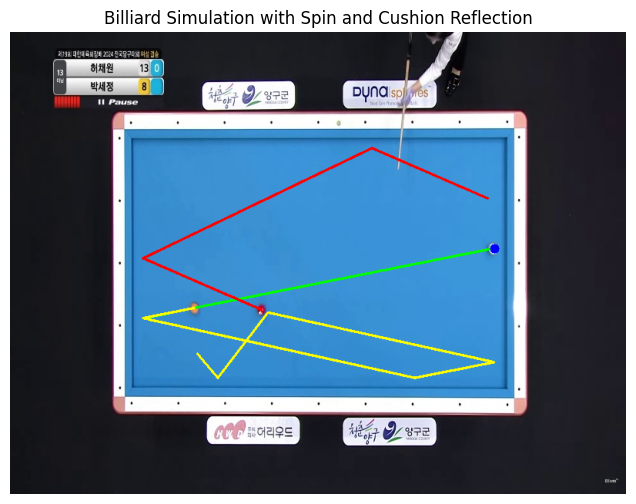

In [23]:
import pymunk
from pymunk import Vec2d
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt

##############################################################################
# 0) 헬퍼 함수: GPU 텐서 → CPU float 변환
##############################################################################
def to_cpu_float(value):
    """
    GPU에서 계산된 torch.Tensor 값이 주어지면 이를 CPU로 가져와 float으로 변환.
    일반 float/int 값이 들어오면 단순히 float(value) 반환.
    """
    if isinstance(value, torch.Tensor):
        return float(value.detach().cpu().item())
    return float(value)

##############################################################################
# 1) YOLO로 추출된 objects, table에서 좌표 읽기 (픽셀 단위)
##############################################################################
# 공의 중심 좌표 계산 및 테이블 경계선 읽기
white_ball  = next(obj for obj in objects if obj["cls_name"] == "white ball")
yellow_ball = next(obj for obj in objects if obj["cls_name"] == "yellow ball")
red_ball    = next(obj for obj in objects if obj["cls_name"] == "red ball")

wx1, wy1 = to_cpu_float(white_ball["x1"]), to_cpu_float(white_ball["y1"])
wx2, wy2 = to_cpu_float(white_ball["x2"]), to_cpu_float(white_ball["y2"])

yx1, yy1 = to_cpu_float(yellow_ball["x1"]), to_cpu_float(yellow_ball["y1"])
yx2, yy2 = to_cpu_float(yellow_ball["x2"]), to_cpu_float(yellow_ball["y2"])

rx1, ry1 = to_cpu_float(red_ball["x1"]), to_cpu_float(red_ball["y1"])
rx2, ry2 = to_cpu_float(red_ball["x2"]), to_cpu_float(red_ball["y2"])

# 공의 중심(픽셀)
white_center_px  = np.array([(wx1+wx2)/2.0, (wy1+wy2)/2.0])  # 흰 공 중심
yellow_center_px = np.array([(yx1+yx2)/2.0, (yy1+yy2)/2.0])  # 노란 공 중심
red_center_px    = np.array([(rx1+rx2)/2.0, (ry1+ry2)/2.0])  # 빨간 공 중심

# 테이블 경계선 (픽셀)
table_min_x = to_cpu_float(table["x1"])
table_min_y = to_cpu_float(table["y1"])
table_max_x = to_cpu_float(table["x2"])
table_max_y = to_cpu_float(table["y2"])

##############################################################################
# 2) 픽셀 → 월드 좌표 변환 (1m = 100px)
##############################################################################
PIXELS_TO_METERS = 100.0  # 픽셀 단위 → 물리 시뮬레이션용 월드 단위

white_pos_world  = (white_center_px  / PIXELS_TO_METERS).tolist()
yellow_pos_world = (yellow_center_px / PIXELS_TO_METERS).tolist()
red_pos_world    = (red_center_px    / PIXELS_TO_METERS).tolist()

table_min_x_world = table_min_x / PIXELS_TO_METERS
table_min_y_world = table_min_y / PIXELS_TO_METERS
table_max_x_world = table_max_x / PIXELS_TO_METERS
table_max_y_world = table_max_y / PIXELS_TO_METERS

##############################################################################
# 3) Pymunk 초기화 + 테이블 쿠션 생성
##############################################################################
space = pymunk.Space()  # 물리 시뮬레이션 공간
space.gravity = (0, 0)  # 중력 없음 (수평 테이블 가정)

mass   = 1.0  # 공의 질량
radius = 0.05  # 공 반지름 (5cm)
moment = pymunk.moment_for_circle(mass, 0, radius)  # 회전 관성

# 쿠션 위치 (테이블 경계선에서 공 반지름만큼 안쪽)
left   = table_min_x_world + radius
right  = table_max_x_world - radius
bottom = table_min_y_world + radius
top    = table_max_y_world - radius

cushion_thickness = 0.01  # 쿠션 두께
cushions = [
    pymunk.Segment(space.static_body, (left, bottom), (right, bottom), cushion_thickness),
    pymunk.Segment(space.static_body, (left, top),    (right, top),    cushion_thickness),
    pymunk.Segment(space.static_body, (left, bottom), (left, top),     cushion_thickness),
    pymunk.Segment(space.static_body, (right, bottom),(right, top),    cushion_thickness),
]
for c in cushions:
    c.elasticity = 0.95  # 쿠션 탄성. 높일수록 공이 덜 느려짐.
    c.friction   = 0.01  # 쿠션 마찰. 낮을수록 공이 더 잘 튕김.
    space.add(c)

##############################################################################
# 4) 공 생성 (흰 공=1, 노란 공=3, 빨간 공=2)
##############################################################################
# 각 공의 탄성과 마찰을 조정할 수 있음.
# 탄성을 높이면 공이 충돌 후 속도가 더 유지되고, 마찰을 낮추면 회전 및 표면 저항이 줄어듦.

# -- 흰 공
white_body = pymunk.Body(mass, moment)
white_body.position = white_pos_world
white_body.angular_damping = 0.1  # 회전 감쇠. 낮을수록 회전이 오래 유지됨.
white_shape = pymunk.Circle(white_body, radius)
white_shape.elasticity = 0.95
white_shape.friction   = 0.02
white_shape.collision_type = 1
space.add(white_body, white_shape)

# -- 노란 공
yellow_body = pymunk.Body(mass, moment)
yellow_body.position = yellow_pos_world
yellow_body.angular_damping = 0.1
yellow_shape = pymunk.Circle(yellow_body, radius)
yellow_shape.elasticity = 0.95
yellow_shape.friction   = 0.02
yellow_shape.collision_type = 3
space.add(yellow_body, yellow_shape)

# -- 빨간 공
red_body = pymunk.Body(mass, moment)
red_body.position = red_pos_world
red_body.angular_damping = 0.1
red_shape = pymunk.Circle(red_body, radius)
red_shape.elasticity = 0.95
red_shape.friction   = 0.02
red_shape.collision_type = 2
space.add(red_body, red_shape)

##############################################################################
# 5) 충돌 핸들러 설정
##############################################################################
def collision_post_solve(arbiter, space, data):
    """
    충돌 후 속도/회전 속도를 출력해 디버깅용 정보 제공.
    """
    sA, sB = arbiter.shapes
    print(f"[충돌] type{sA.collision_type} <-> type{sB.collision_type}, "
          f"velA=({sA.body.velocity.x:.2f},{sA.body.velocity.y:.2f}), "
          f"velB=({sB.body.velocity.x:.2f},{sB.body.velocity.y:.2f}), "
          f"angVelA={sA.body.angular_velocity:.2f}, angVelB={sB.body.angular_velocity:.2f}")
    return True

for ctypeA, ctypeB in [(1,3), (1,2), (3,2)]:
    handler = space.add_collision_handler(ctypeA, ctypeB)
    handler.post_solve = collision_post_solve

##############################################################################
# 6) 흰 공 초기 속도 및 타점 적용
##############################################################################
strength_gauge = 6  # 초기 속도 게이지. (1~10)
max_speed = 1.0     # 게이지=10일 때 최대 속도 (1 m/s)
initial_speed = (strength_gauge / 10.0) * max_speed

# 흰 공에서 노란 공 방향으로 기본 벡터 계산
base_vec = (yellow_body.position - white_body.position).normalized()

# 타점: 공 중심에서 약간 오른쪽 (3cm)으로 치기
impact_offset_world = Vec2d(0.03, 0.0)
impact_point_world = white_body.position + impact_offset_world

# 흰 공에 초기 속도와 회전력을 부여
impulse_magnitude = initial_speed * mass
impulse_vec = base_vec * impulse_magnitude
white_body.apply_impulse_at_world_point(impulse_vec, impact_point_world)

impact_point_px = impact_point_world * PIXELS_TO_METERS  # 타점을 픽셀로 변환

##############################################################################
# 7) 시뮬레이션 수행
##############################################################################
dt = 1/60.0  # 시간 스텝 (1/60초)
max_steps = 3000  # 최대 스텝 수
stop_threshold = 0.02  # 정지 판정 속도

positions_white  = []
positions_yellow = []
positions_red    = []

# 추가 마찰 계수. 높이면 공의 속도가 더 빠르게 감속됨.
global_friction_coef = 0.01

for step in range(max_steps):
    space.step(dt)  # 시뮬레이션 진행

    # 마찰로 인해 속도 감소
    white_body.velocity  *= (1 - global_friction_coef * dt)
    yellow_body.velocity *= (1 - global_friction_coef * dt)
    red_body.velocity    *= (1 - global_friction_coef * dt)

    # 너무 느리면 정지
    if white_body.velocity.length < stop_threshold:
        white_body.velocity = Vec2d(0, 0)
    if yellow_body.velocity.length < stop_threshold:
        yellow_body.velocity = Vec2d(0, 0)
    if red_body.velocity.length < stop_threshold:
        red_body.velocity = Vec2d(0, 0)

    # 궤적 저장
    positions_white.append( (white_body.position.x,  white_body.position.y) )
    positions_yellow.append((yellow_body.position.x, yellow_body.position.y))
    positions_red.append(   (red_body.position.x,    red_body.position.y) )

    # 모든 공이 멈추면 시뮬레이션 종료
    if (white_body.velocity.length == 0 and
        yellow_body.velocity.length == 0 and
        red_body.velocity.length == 0):
        print(f"[시뮬레이션 종료] step={step}")
        break

##############################################################################
# 8) 시각화 (OpenCV)
##############################################################################
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Could not load image: {image_path}")

# 궤적을 그리는 함수
def draw_trajectory(img, positions, color_bgr):
    for i in range(len(positions)-1):
        x1, y1 = positions[i]
        x2, y2 = positions[i+1]
        pt1 = (int(x1 * PIXELS_TO_METERS), int(y1 * PIXELS_TO_METERS))
        pt2 = (int(x2 * PIXELS_TO_METERS), int(y2 * PIXELS_TO_METERS))
        cv2.line(img, pt1, pt2, color_bgr, 2)

# 각 공의 궤적을 그리기
draw_trajectory(image, positions_white,  (0, 255, 0))  # 흰 공: 녹색
draw_trajectory(image, positions_yellow, (0, 255, 255))# 노란 공: 노랑
draw_trajectory(image, positions_red,    (0, 0, 255))  # 빨간 공: 빨강

# 타점 시각화 (파란 점)
impact_pt_int = (int(impact_point_px.x), int(impact_point_px.y))
cv2.circle(image, impact_pt_int, 6, (255, 0, 0), -1)  # 타점 표시

##############################################################################
# 9) matplotlib로 시각화
##############################################################################
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 6))
plt.imshow(image_rgb)
plt.axis("off")
plt.title("Billiard Simulation with Spin and Cushion Reflection")
plt.show()


[충돌] type1 <-> type3, velA=(-0.03,0.01), velB=(-0.52,0.10), angVelA=2.80, angVelB=-0.01
[충돌] type3 <-> type2, velA=(-0.04,0.06), velB=(-0.31,-0.13), angVelA=0.01, angVelB=0.01


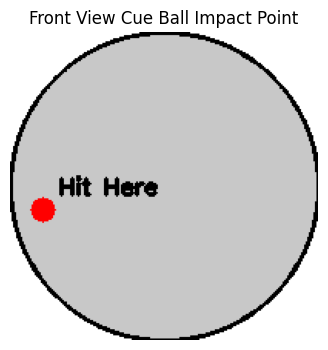

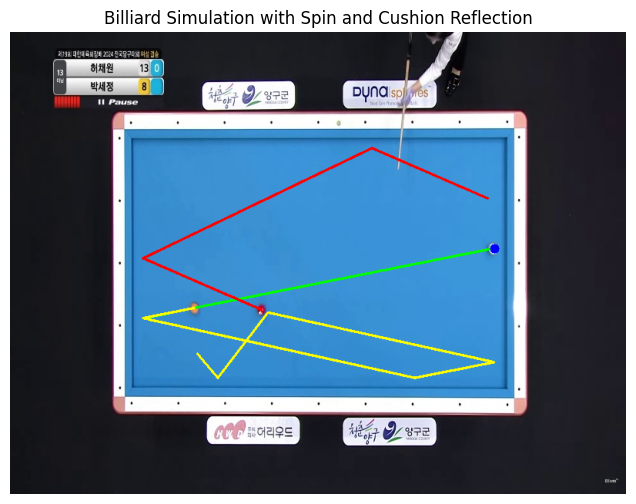

In [25]:
import pymunk
from pymunk import Vec2d
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt

##############################################################################
# (A) 헬퍼 함수: GPU 텐서 → CPU float 변환
##############################################################################
def to_cpu_float(value):
    """
    GPU에서 계산된 torch.Tensor 값이 주어지면 CPU로 이동 후 float 변환.
    일반 float/int라면 그대로 float(value).
    """
    if isinstance(value, torch.Tensor):
        return float(value.detach().cpu().item())
    return float(value)

##############################################################################
# (B) YOLO로 추출된 objects, table에서 좌표 읽기 (픽셀 단위)
##############################################################################
white_ball  = next(obj for obj in objects if obj["cls_name"] == "white ball")
yellow_ball = next(obj for obj in objects if obj["cls_name"] == "yellow ball")
red_ball    = next(obj for obj in objects if obj["cls_name"] == "red ball")

wx1, wy1 = to_cpu_float(white_ball["x1"]), to_cpu_float(white_ball["y1"])
wx2, wy2 = to_cpu_float(white_ball["x2"]), to_cpu_float(white_ball["y2"])

yx1, yy1 = to_cpu_float(yellow_ball["x1"]), to_cpu_float(yellow_ball["y1"])
yx2, yy2 = to_cpu_float(yellow_ball["x2"]), to_cpu_float(yellow_ball["y2"])

rx1, ry1 = to_cpu_float(red_ball["x1"]), to_cpu_float(red_ball["y1"])
rx2, ry2 = to_cpu_float(red_ball["x2"]), to_cpu_float(red_ball["y2"])

# 공 중심(픽셀)
white_center_px  = np.array([(wx1+wx2)/2.0, (wy1+wy2)/2.0])
yellow_center_px = np.array([(yx1+yx2)/2.0, (yy1+yy2)/2.0])
red_center_px    = np.array([(rx1+rx2)/2.0, (ry1+ry2)/2.0])

# 테이블(픽셀)
table_min_x = to_cpu_float(table["x1"])
table_min_y = to_cpu_float(table["y1"])
table_max_x = to_cpu_float(table["x2"])
table_max_y = to_cpu_float(table["y2"])

##############################################################################
# (C) 픽셀 → 월드 좌표 변환 (1m=100px)
##############################################################################
PIXELS_TO_METERS = 100.0

white_pos_world  = (white_center_px  / PIXELS_TO_METERS).tolist()
yellow_pos_world = (yellow_center_px / PIXELS_TO_METERS).tolist()
red_pos_world    = (red_center_px    / PIXELS_TO_METERS).tolist()

table_min_x_world = table_min_x / PIXELS_TO_METERS
table_min_y_world = table_min_y / PIXELS_TO_METERS
table_max_x_world = table_max_x / PIXELS_TO_METERS
table_max_y_world = table_max_y / PIXELS_TO_METERS

##############################################################################
# (D) Pymunk 초기화 + 테이블 쿠션 생성
##############################################################################
space = pymunk.Space()
space.gravity = (0, 0)

mass   = 1.0
radius = 0.05  # 5cm
moment = pymunk.moment_for_circle(mass, 0, radius)

left   = table_min_x_world + radius
right  = table_max_x_world - radius
bottom = table_min_y_world + radius
top    = table_max_y_world - radius

cushion_thickness = 0.01
cushions = [
    pymunk.Segment(space.static_body, (left, bottom), (right, bottom), cushion_thickness),
    pymunk.Segment(space.static_body, (left, top),    (right, top),    cushion_thickness),
    pymunk.Segment(space.static_body, (left, bottom), (left, top),     cushion_thickness),
    pymunk.Segment(space.static_body, (right, bottom),(right, top),    cushion_thickness),
]
for c in cushions:
    c.elasticity = 0.95
    c.friction   = 0.01
    space.add(c)

##############################################################################
# (E) 공 3개 생성 (흰=1, 노랑=3, 빨강=2)
##############################################################################
white_body = pymunk.Body(mass, moment)
white_body.position = white_pos_world
white_body.angular_damping = 0.1
white_shape = pymunk.Circle(white_body, radius)
white_shape.elasticity = 0.95
white_shape.friction   = 0.02
white_shape.collision_type = 1
space.add(white_body, white_shape)

yellow_body = pymunk.Body(mass, moment)
yellow_body.position = yellow_pos_world
yellow_body.angular_damping = 0.1
yellow_shape = pymunk.Circle(yellow_body, radius)
yellow_shape.elasticity = 0.95
yellow_shape.friction   = 0.02
yellow_shape.collision_type = 3
space.add(yellow_body, yellow_shape)

red_body = pymunk.Body(mass, moment)
red_body.position = red_pos_world
red_body.angular_damping = 0.1
red_shape = pymunk.Circle(red_body, radius)
red_shape.elasticity = 0.95
red_shape.friction   = 0.02
red_shape.collision_type = 2
space.add(red_body, red_shape)

##############################################################################
# (F) 충돌 핸들러
##############################################################################
def collision_post_solve(arbiter, space, data):
    sA, sB = arbiter.shapes
    print(f"[충돌] type{sA.collision_type} <-> type{sB.collision_type}, "
          f"velA=({sA.body.velocity.x:.2f},{sA.body.velocity.y:.2f}), "
          f"velB=({sB.body.velocity.x:.2f},{sB.body.velocity.y:.2f}), "
          f"angVelA={sA.body.angular_velocity:.2f}, angVelB={sB.body.angular_velocity:.2f}")
    return True

for ctypeA, ctypeB in [(1,3), (1,2), (3,2)]:
    h = space.add_collision_handler(ctypeA, ctypeB)
    h.post_solve = collision_post_solve

##############################################################################
# (G) 흰 공 초기 속도 + 타점(Off-center) 적용
##############################################################################
strength_gauge = 6     # 1~10
max_speed = 1.0        # 게이지=10 -> 1 m/s
initial_speed = (strength_gauge / 10.0) * max_speed

# (노란 공 - 흰 공) 벡터
base_vec = (yellow_body.position - white_body.position).normalized()

impact_offset_world = Vec2d(0.03, 0.0)
impact_point_world  = white_body.position + impact_offset_world

impulse_magnitude = initial_speed * mass
impulse_vec       = base_vec * impulse_magnitude
white_body.apply_impulse_at_world_point(impulse_vec, impact_point_world)

impact_point_px = impact_point_world * PIXELS_TO_METERS

##############################################################################
# (H) 시뮬레이션
##############################################################################
dt = 1/60.0
max_steps = 3000
stop_threshold = 0.02

positions_white  = []
positions_yellow = []
positions_red    = []

global_friction_coef = 0.01

for step in range(max_steps):
    space.step(dt)

    # 마찰 감속
    white_body.velocity  *= (1 - global_friction_coef * dt)
    yellow_body.velocity *= (1 - global_friction_coef * dt)
    red_body.velocity    *= (1 - global_friction_coef * dt)

    # 느리면 정지
    if white_body.velocity.length < stop_threshold:
        white_body.velocity = Vec2d(0, 0)
    if yellow_body.velocity.length < stop_threshold:
        yellow_body.velocity = Vec2d(0, 0)
    if red_body.velocity.length < stop_threshold:
        red_body.velocity = Vec2d(0, 0)

    positions_white.append( (white_body.position.x,  white_body.position.y) )
    positions_yellow.append((yellow_body.position.x, yellow_body.position.y))
    positions_red.append(   (red_body.position.x,    red_body.position.y) )

    if (white_body.velocity.length == 0 and
        yellow_body.velocity.length == 0 and
        red_body.velocity.length == 0):
        print(f"[시뮬레이션 종료] step={step}")
        break

##############################################################################
# (I) 시각화 (OpenCV) + matplotlib
##############################################################################
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Could not load image: {image_path}")

def draw_trajectory(img, positions, color_bgr):
    for i in range(len(positions)-1):
        x1, y1 = positions[i]
        x2, y2 = positions[i+1]
        pt1 = (int(x1 * PIXELS_TO_METERS), int(y1 * PIXELS_TO_METERS))
        pt2 = (int(x2 * PIXELS_TO_METERS), int(y2 * PIXELS_TO_METERS))
        cv2.line(img, pt1, pt2, color_bgr, 2)

draw_trajectory(image, positions_white,  (0,255,0))    # 흰=녹색
draw_trajectory(image, positions_yellow, (0,255,255))  # 노랑=노랑
draw_trajectory(image, positions_red,    (0,0,255))    # 빨강=빨강

impact_pt_int = (int(impact_point_px.x), int(impact_point_px.y))
cv2.circle(image, impact_pt_int, 6, (255, 0, 0), -1)

##############################################################################
# (J) 정면 타점 표시 함수
##############################################################################
def show_front_hit_point(cue_ball, target_1):
    """
    cue_ball, target_1: (x1,y1,x2,y2)를 key로 갖는 dict (ex: YOLO bounding box).
    
    'cue_ball' 중심에서 'target_1' 중심까지의 방향벡터를 구해,
    정면에서 본 공의 표면에 타점을 빨간 점으로 표시함.
    """
    # 1) 흰 공, 목표 공 중심(픽셀, CPU float 변환)
    cx1 = to_cpu_float(cue_ball["x1"])
    cx2 = to_cpu_float(cue_ball["x2"])
    cy1 = to_cpu_float(cue_ball["y1"])
    cy2 = to_cpu_float(cue_ball["y2"])

    tx1 = to_cpu_float(target_1["x1"])
    tx2 = to_cpu_float(target_1["x2"])
    ty1 = to_cpu_float(target_1["y1"])
    ty2 = to_cpu_float(target_1["y2"])

    cue_x = (cx1 + cx2) / 2.0
    cue_y = (cy1 + cy2) / 2.0
    t1_x = (tx1 + tx2) / 2.0
    t1_y = (ty1 + ty2) / 2.0

    # 2) 방향 벡터
    dx = t1_x - cue_x
    dy = t1_y - cue_y
    direction = np.array([dx, dy], dtype=np.float32)
    dist = np.linalg.norm(direction)
    if dist > 1e-7:
        direction /= dist
    else:
        direction = np.array([1.0, 0.0], dtype=np.float32)

    # 3) 정면 이미지 위에 공(원) 그리기
    radius = 100
    center = (radius, radius)
    ball_image = np.ones((2*radius, 2*radius, 3), dtype=np.uint8) * 255

    # 회색 공 + 검은 테두리
    cv2.circle(ball_image, center, radius, (200, 200, 200), -1)
    cv2.circle(ball_image, center, radius, (0, 0, 0), 2)

    # 4) 공 표면 타점
    hit_x = int(center[0] + direction[0] * radius * 0.8)
    hit_y = int(center[1] + direction[1] * radius * 0.8)
    cv2.circle(ball_image, (hit_x, hit_y), 8, (0, 0, 255), -1)
    cv2.putText(ball_image, "Hit Here", (hit_x + 10, hit_y - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

    # 시각화
    ball_image_rgb = cv2.cvtColor(ball_image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(4,4))
    plt.imshow(ball_image_rgb)
    plt.axis("off")
    plt.title("Front View Cue Ball Impact Point")
    plt.show()

# 정면 타점 표시 예시: 흰 공 vs 노란 공
show_front_hit_point(white_ball, yellow_ball)

# 최종 결과 표시
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,6))
plt.imshow(image_rgb)
plt.axis("off")
plt.title("Billiard Simulation with Spin and Cushion Reflection")
plt.show()


StopIteration: 